In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings
warnings.simplefilter(action="ignore")

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [3]:
# GENEL ANALİZ 

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

In [8]:
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [9]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes  

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    #cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    #num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]  
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [12]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Churn']

In [13]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [14]:
cat_but_car

['customerID']

In [15]:
# KATEGORİK DEĞİŞKENLERİN ANALİZİ

In [16]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

        gender     Ratio
Male      3555  50.47565
Female    3488  49.52435
##########################################


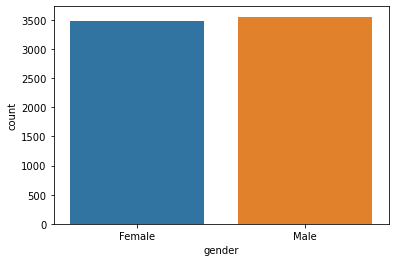

     Partner     Ratio
No      3641  51.69672
Yes     3402  48.30328
##########################################


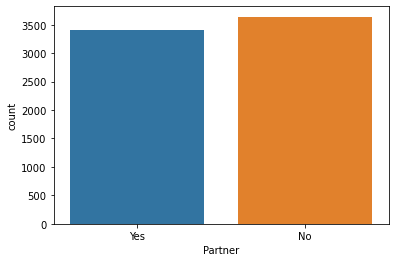

     Dependents      Ratio
No         4933  70.041176
Yes        2110  29.958824
##########################################


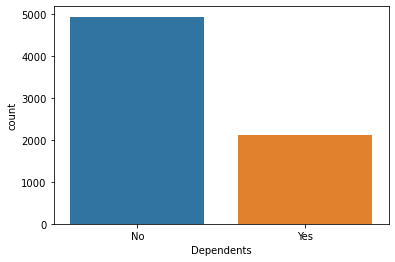

     PhoneService      Ratio
Yes          6361  90.316626
No            682   9.683374
##########################################


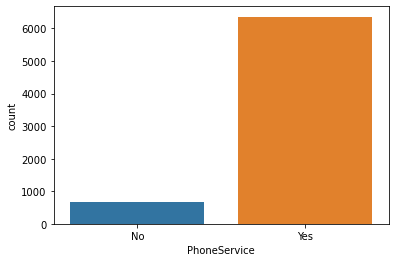

                  MultipleLines      Ratio
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
##########################################


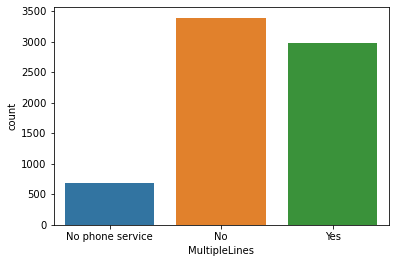

             InternetService      Ratio
Fiber optic             3096  43.958540
DSL                     2421  34.374556
No                      1526  21.666903
##########################################


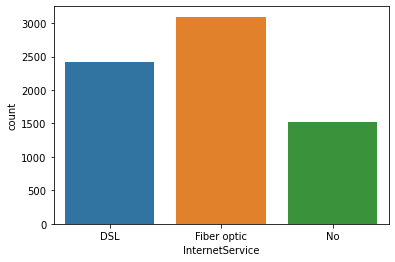

                     OnlineSecurity      Ratio
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903
##########################################


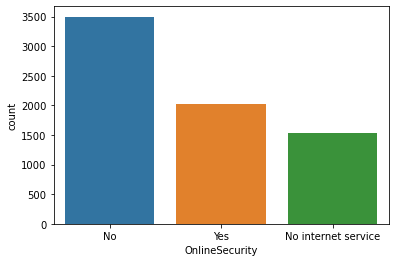

                     OnlineBackup      Ratio
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526  21.666903
##########################################


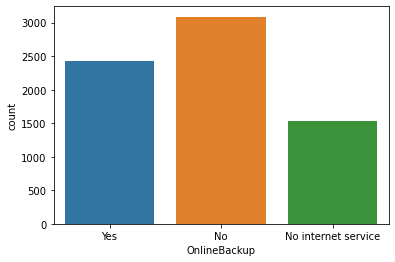

                     DeviceProtection      Ratio
No                               3095  43.944342
Yes                              2422  34.388755
No internet service              1526  21.666903
##########################################


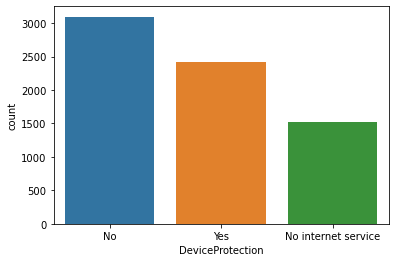

                     TechSupport      Ratio
No                          3473  49.311373
Yes                         2044  29.021724
No internet service         1526  21.666903
##########################################


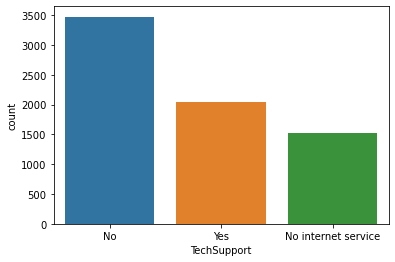

                     StreamingTV      Ratio
No                          2810  39.897771
Yes                         2707  38.435326
No internet service         1526  21.666903
##########################################


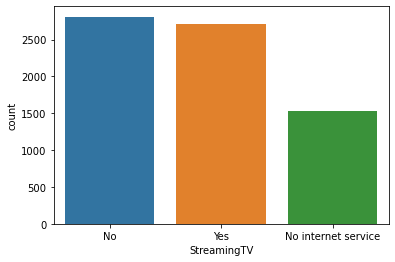

                     StreamingMovies      Ratio
No                              2785  39.542808
Yes                             2732  38.790288
No internet service             1526  21.666903
##########################################


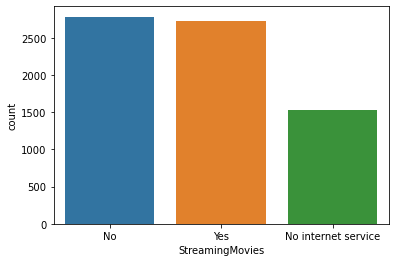

                Contract      Ratio
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383
##########################################


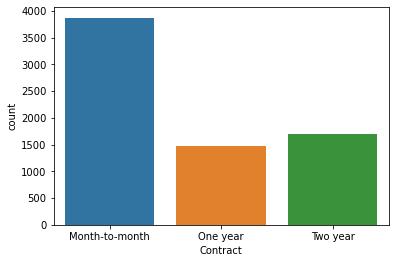

     PaperlessBilling      Ratio
Yes              4171  59.221922
No               2872  40.778078
##########################################


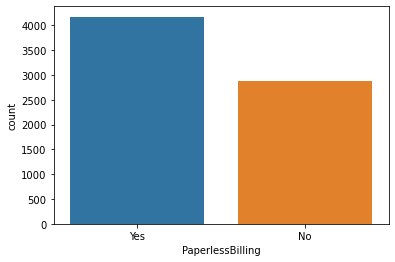

                           PaymentMethod      Ratio
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109
##########################################


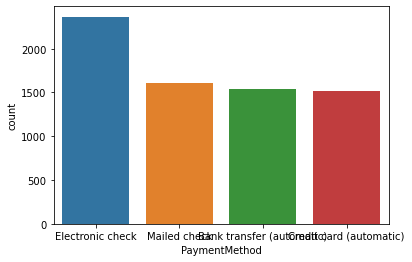

   SeniorCitizen      Ratio
0           5901  83.785319
1           1142  16.214681
##########################################


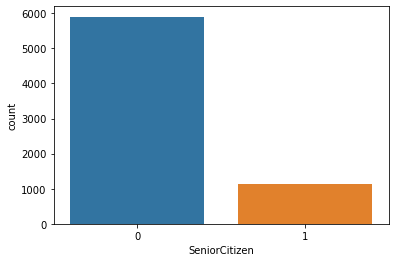

   Churn      Ratio
0   5174  73.463013
1   1869  26.536987
##########################################


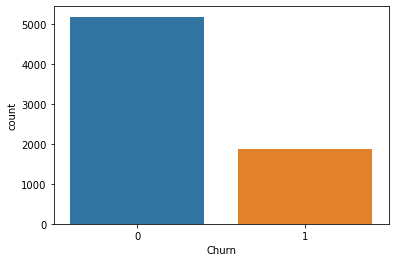

In [17]:
for col in cat_cols:
    cat_summary(df,col,True)

In [18]:
# NUMERİK DEĞİŞKENLERİN ANALİZİ

In [19]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()


count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


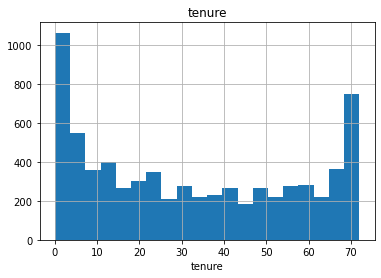

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


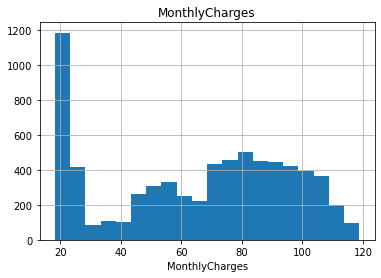

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TotalCharges, dtype: float64


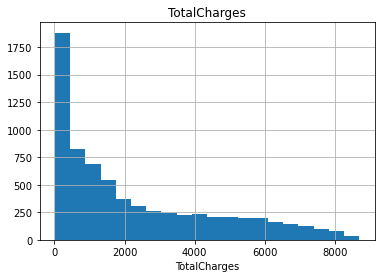

In [20]:
for col in num_cols:
    num_summary(df,col,True)

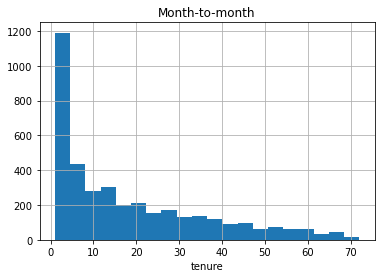

In [21]:
df[df["Contract"] == "Month-to-month"]["tenure"].hist(bins=20)
plt.xlabel("tenure")
plt.title("Month-to-month")
plt.show()

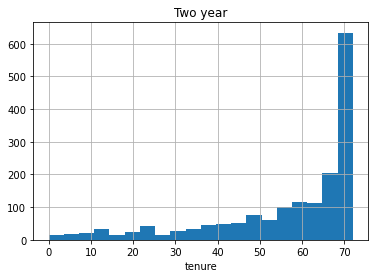

In [22]:
df[df["Contract"] == "Two year"]["tenure"].hist(bins=20)
plt.xlabel("tenure")
plt.title("Two year")
plt.show()

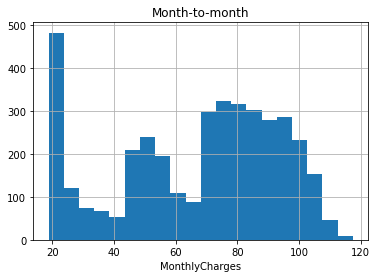

In [23]:
df[df["Contract"] == "Month-to-month"]["MonthlyCharges"].hist(bins=20)
plt.xlabel("MonthlyCharges")
plt.title("Month-to-month")
plt.show()

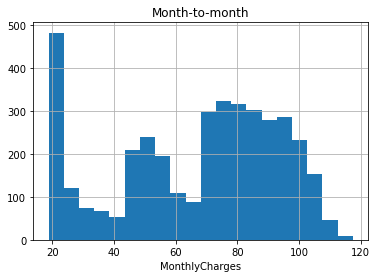

In [24]:
df[df["Contract"] == "Month-to-month"]["MonthlyCharges"].hist(bins=20)
plt.xlabel("MonthlyCharges")
plt.title("Month-to-month")
plt.show()


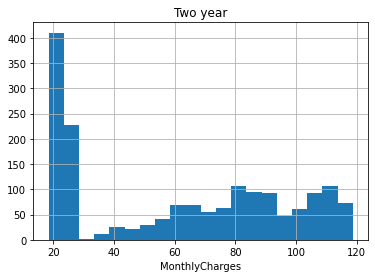

In [25]:
df[df["Contract"] == "Two year"]["MonthlyCharges"].hist(bins=20)
plt.xlabel("MonthlyCharges")
plt.title("Two year")
plt.show()

In [26]:
# NUMERİK DEĞİŞKENLERİN TARGET GÖRE ANALİZİ

In [27]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [28]:
for col in num_cols:
    target_summary_with_num(df,"Churn",col)

          tenure
Churn           
0      37.569965
1      17.979133


       MonthlyCharges
Churn                
0           61.265124
1           74.441332


       TotalCharges
Churn              
0       2555.344141
1       1531.796094




In [29]:
# KATEGORİK DEĞİŞKENLERİN TARGET GÖRE ANALİZİ

In [30]:
def target_summary_with_cat(dataframe,target,categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

In [31]:
for col in cat_cols:
    target_summary_with_cat(df,"Churn",col)


gender
        TARGET_MEAN  Count     Ratio
Female     0.269209   3488  49.52435
Male       0.261603   3555  50.47565


Partner
         TARGET_MEAN  Count     Ratio
Partner                              
No          0.329580   3641  51.69672
Yes         0.196649   3402  48.30328


Dependents
            TARGET_MEAN  Count      Ratio
Dependents                               
No             0.312791   4933  70.041176
Yes            0.154502   2110  29.958824


PhoneService
     TARGET_MEAN  Count      Ratio
No      0.249267    682   9.683374
Yes     0.267096   6361  90.316626


MultipleLines
                  TARGET_MEAN  Count      Ratio
No                   0.250442   3390  48.132898
No phone service     0.249267    682   9.683374
Yes                  0.286099   2971  42.183729


InternetService
             TARGET_MEAN  Count      Ratio
DSL             0.189591   2421  34.374556
Fiber optic     0.418928   3096  43.958540
No              0.074050   1526  21.666903


OnlineSecurity
    

In [32]:
# KORELASYON

In [33]:
df[num_cols].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.00000,0.247900,0.825880
MonthlyCharges,0.24790,1.000000,0.651065
TotalCharges,0.82588,0.651065,1.000000


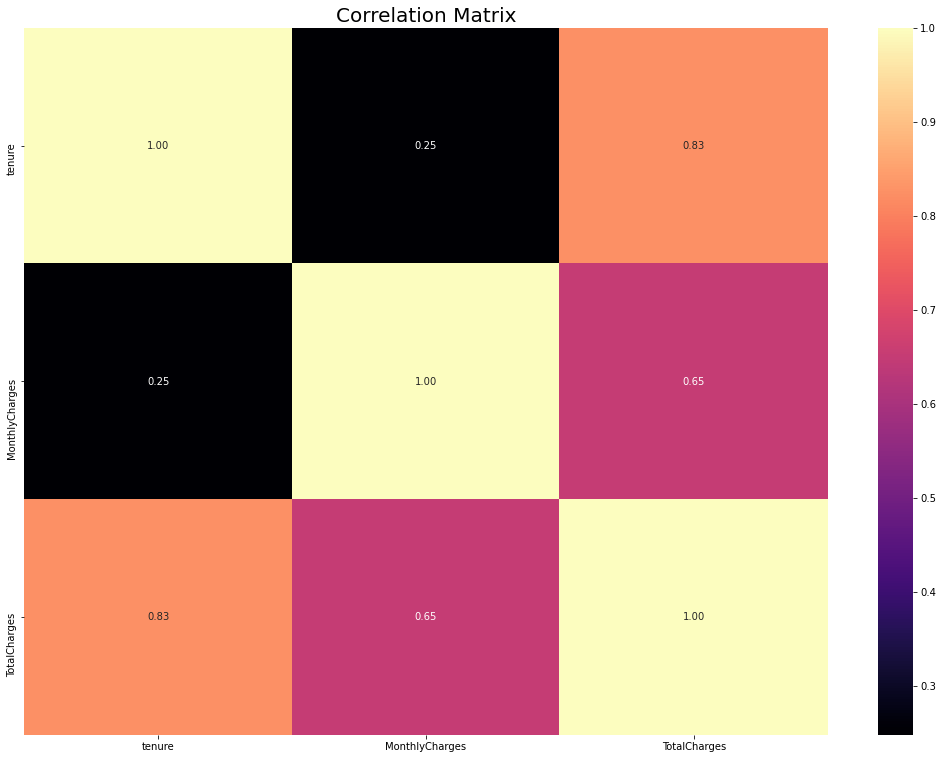

In [34]:
#Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [35]:
df.corrwith(df["Churn"]).sort_values(ascending=False)

Churn             1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
TotalCharges     -0.199484
tenure           -0.352229
dtype: float64

In [36]:
# FEATURE ENGINEERING

In [37]:
# EKSİK DEĞER ANALİZİ

In [38]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0 ]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [39]:
na_columns = missing_values_table(df, na_name=True)

              n_miss  ratio
TotalCharges      11   0.16


In [40]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)  

In [41]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [42]:
# BASE MODEL KURULUMU

In [43]:
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols


['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [44]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
dff = one_hot_encoder(dff, cat_cols, drop_first = True)

In [45]:
y = dff["Churn"]
X = dff.drop(["Churn","customerID"], axis=1)

In [46]:
models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART',DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('SVM', SVC(gamma='auto', random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ('LightGBM', LGBMClassifier(random_state=12345)),
          ('CatBoost', CatBoostClassifier(verbose=False, random_state=12345))]

In [47]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")


########## LR ##########
Accuracy: 0.8053
Auc: 0.8432
Recall: 0.5436
Precision: 0.663
F1: 0.5969
########## KNN ##########
Accuracy: 0.7629
Auc: 0.747
Recall: 0.4462
Precision: 0.5687
F1: 0.4996
########## CART ##########
Accuracy: 0.7277
Auc: 0.6579
Recall: 0.504
Precision: 0.4876
F1: 0.4954
########## RF ##########
Accuracy: 0.792
Auc: 0.8254
Recall: 0.4837
Precision: 0.6451
F1: 0.5526
########## SVM ##########
Accuracy: 0.7696
Auc: 0.7141
Recall: 0.2905
Precision: 0.6495
F1: 0.4009
########## XGB ##########
Accuracy: 0.783
Auc: 0.8243
Recall: 0.5126
Precision: 0.6107
F1: 0.5568
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[Lig

In [48]:
# AYKIRI DEĞER ANALİZİ

In [49]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [50]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
         
    

In [51]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [52]:
for col in num_cols:
    print(col, check_outlier(df,col))
    if check_outlier(df,col):
        replace_with_thresholds(df,col)

tenure False
MonthlyCharges False
TotalCharges False


In [56]:
# ÖZELLİK ÇIKARIMI

In [57]:
# Tenure  değişkeninden yıllık kategorik değişken oluşturma
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [58]:
# Kontratı 1 veya 2 yıllık müşterileri Engaged olarak belirtme
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [59]:
# Herhangi bir destek, yedek veya koruma almayan kişiler
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [60]:
# Aylık sözleşmesi bulunan ve genç olan müşteriler
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"]== 0) and (x["SeniorCitizen"]== 0) else 0, axis=1)

In [61]:
# Kişinin toplam aldığı servis sayısı
df["NEW_TotalServices"] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]=="Yes").sum(axis=1)

In [63]:
# Herhangi bir streaming hizmeti alan kişiler
df["NEW_FLAG_ANY_STREAMING"]= df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or ( x["StreamingMovies"]== "Yes") else 0, axis=1)

In [65]:
# Kişi otomatik ödeme yapıyor mu?
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [66]:
# ortalama aylık ödeme
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

In [67]:
# Güncel Fiyatın ortalama fiyata göre artışı
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

In [68]:
# Servis başına ücret
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [69]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,0-1 Year,0,1,1,1,0,0,14.925000,0.500000,14.9250
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,2-3 Year,1,1,0,3,0,0,53.985714,0.947949,14.2375
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,0-1 Year,0,1,1,3,0,0,36.050000,0.669452,13.4625
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,3-4 Year,1,1,0,3,0,1,40.016304,0.946012,10.5750
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,0-1 Year,0,1,1,1,0,0,50.550000,0.714993,35.3500


In [70]:
# ENCODING
##################################

In [71]:
# Değişkenlerin tiplerine göre ayrılması işlemi

In [72]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 8


In [74]:
# LABEL ENCODING

In [75]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [78]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [79]:
for col in binary_cols:
    df = label_encoder(df, col)

In [76]:
# One-Hot Encoding

In [80]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'SeniorCitizen',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [81]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [82]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [83]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,1,1,0,0
1,5575-GNVDE,1,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,0,1,1,0,0,0
2,3668-QPYBK,1,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,1,1,0,0
3,7795-CFOCW,1,0,0,45,0,0,42.30,1840.75,0,...,0,1,0,0,0,1,1,0,0,1
4,9237-HQITU,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,1,1,0,0


In [84]:
# MODELLEME

In [85]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

In [86]:
models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('SVM', SVC(gamma='auto', random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

In [87]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")


########## LR ##########
Accuracy: 0.8031
Auc: 0.8445
Recall: 0.5078
Precision: 0.6716
F1: 0.5774
########## KNN ##########
Accuracy: 0.7701
Auc: 0.7542
Recall: 0.466
Precision: 0.585
F1: 0.5178
########## CART ##########
Accuracy: 0.728
Auc: 0.6574
Recall: 0.5035
Precision: 0.4875
F1: 0.4953
########## RF ##########
Accuracy: 0.7914
Auc: 0.8269
Recall: 0.4998
Precision: 0.6374
F1: 0.5598
########## SVM ##########
Accuracy: 0.7681
Auc: 0.7255
Recall: 0.2579
Precision: 0.6657
F1: 0.3708
########## XGB ##########
Accuracy: 0.7811
Auc: 0.8235
Recall: 0.496
Precision: 0.6082
F1: 0.5459
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1430
[L

In [88]:
# Random Forests

In [89]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

rf_best_grid.best_params_

rf_best_grid.best_score_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)


cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.4min finished


0.8401709849253333

In [97]:
# XGBoost

In [90]:
xgboost_model = XGBClassifier(random_state=17)

xgboost_params = {"learning_rate": [0.1, 0.01, 0.001],
                  "max_depth": [5, 8, 12, 15, 20],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.5, 0.7, 1]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(xgboost_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:  5.1min finished


0.8446925608126927

In [91]:
# LightGBM

In [92]:
lgbm_model = LGBMClassifier(random_state=17)

lgbm_params = {"learning_rate": [0.01, 0.1, 0.001],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   25.0s finished


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1430
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1430
[LightGBM] [Info] Number of data points in the train set: 7043, number of used featu

0.8453944604392929

In [93]:
# CatBoost

In [94]:
catboost_model = CatBoostClassifier(random_state=17, verbose=False)

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(catboost_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.0s finished


0.8469210460675232

In [95]:
# Feature Importance

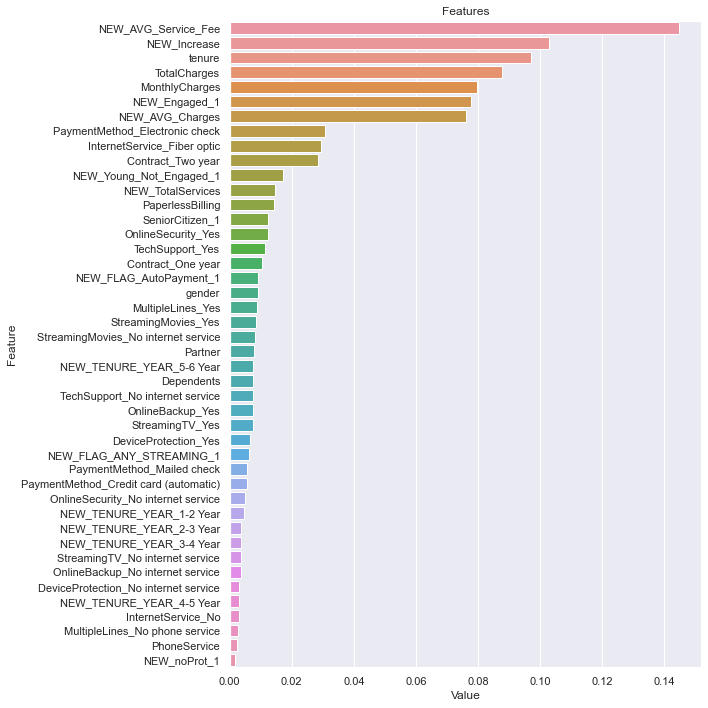

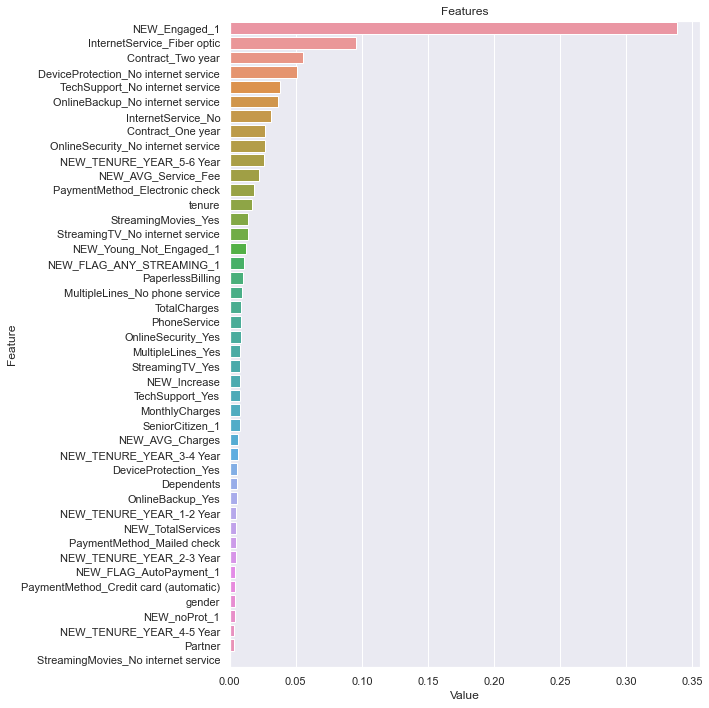

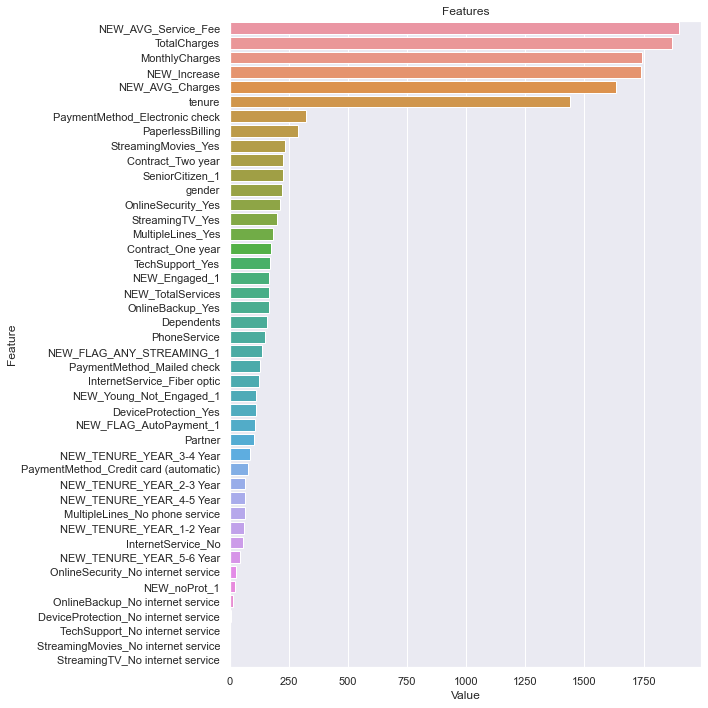

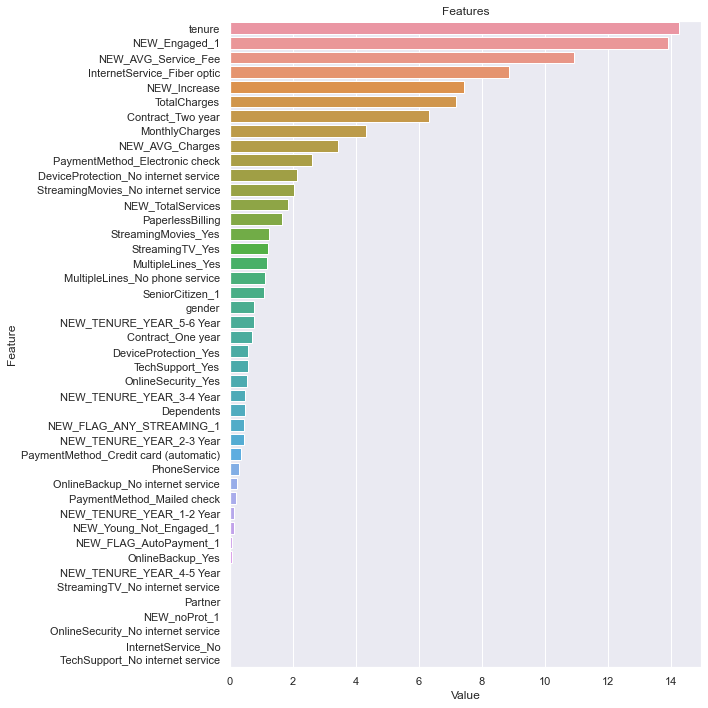

In [96]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)
plot_importance(xgboost_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)